# A Notebook for Calculating Weight by Target Weight Distribution

In [1]:
import shutil
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

import awkward as ak

import vector
vector.register_awkward()
vector.register_numba()

## load dataset and get the target weight distribution

### simple load dataset

In [2]:
def awk2npy(arr):
    return np.array(arr)[..., np.newaxis]

In [3]:
training_path = "../../data/hhh_mh120-130_training.h5"
post_path = "../../data/merged_training_all_w_weights.h5"

post_path = shutil.copy2(training_path, post_path)

In [4]:
f = h5.File(post_path, 'a')

In [5]:
f.keys()

<KeysViewHDF5 ['INPUTS', 'TARGETS']>

In [6]:
for i in range(1, 4):
    exec(f"rh{i}_mass = awk2npy(f[\'TARGETS\'][\'h{i}\'][\'mh\'])")
    exec(f"bh{i}_mass = awk2npy(f[\'TARGETS\'][\'bh{i}\'][\'mh\'])")

In [7]:
for i in range(1, 4):
    exec(f"rh{i}_mask = awk2npy(f[\'TARGETS\'][\'h{i}\'][\'mask\'])")
    exec(f"bh{i}_mask = awk2npy(f[\'TARGETS\'][\'bh{i}\'][\'mask\'])")

In [8]:
rh_mass_list = []
for i in range(1, 4):
    exec(f"rh_mass_list.append(rh{i}_mass)")
rh_mass = np.concatenate(rh_mass_list, axis=1)

In [9]:
rh_mask_list = []
for i in range(1, 4):
    exec(f"rh_mask_list.append(rh{i}_mask)")
rh_mask = np.concatenate(rh_mask_list, axis=1)

In [10]:
bh_mass_list = []
for i in range(1, 4):
    exec(f"bh_mass_list.append(bh{i}_mass)")
bh_mass = np.concatenate(bh_mass_list, axis=1)

In [11]:
bh_mask_list = []
for i in range(1, 4):
    exec(f"bh_mask_list.append(bh{i}_mask)")
bh_mask = np.concatenate(bh_mask_list, axis=1)

In [12]:
j_pt = np.array(f["INPUTS"]["Jets"]["pt"])
j_eta = np.array(f["INPUTS"]["Jets"]["eta"])
j_phi = np.array(f["INPUTS"]["Jets"]["phi"])
j_mass = np.array(f["INPUTS"]["Jets"]["mass"])

In [13]:
js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D",
    )

In [14]:
for i in range(1, 4):
    exec(f"rh{i}_b1s = awk2npy(f[\"TARGETS\"][\"h{i}\"][\"b1\"])")
    exec(f"rh{i}_b2s = awk2npy(f[\"TARGETS\"][\"h{i}\"][\"b2\"])")

In [15]:
rh_b1_list = []
for i in range(1, 4):
    exec(f"rh_b1_list.append(rh{i}_b1s)")
rh_b1 = np.concatenate(rh_b1_list, axis=1)

In [16]:
rh_b2_list = []
for i in range(1, 4):
    exec(f"rh_b2_list.append(rh{i}_b2s)")
rh_b2 = np.concatenate(rh_b2_list, axis=1)

### calculate resolved reco mass

In [17]:
b1s = js[np.arange(rh_b1.shape[0])[:, None], rh_b1]
b2s = js[np.arange(rh_b2.shape[0])[:, None], rh_b2]

In [18]:
rH_reco = (b1s+b2s)[rh_mask]
rH_reco_mass = rH_reco.M

### plot the resolved Higgs mass distribution

Text(0.5, 0, 'Reco Resolved Higgs Mass (GeV)')

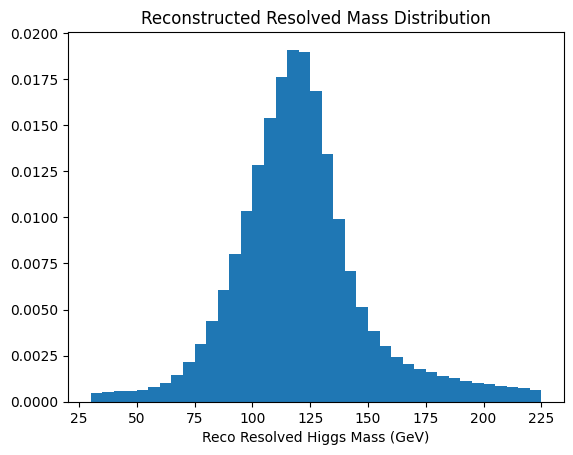

In [19]:
plt.hist(rH_reco_mass, bins=np.arange(30, 230, 5), density=True)
plt.title("Reconstructed Resolved Mass Distribution")
plt.xlabel('Reco Resolved Higgs Mass (GeV)')

### calculate boosted reco mass

In [20]:
fj_pt = np.array(f["INPUTS"]["BoostedJets"]["fj_pt"])
fj_eta = np.array(f["INPUTS"]["BoostedJets"]["fj_eta"])
fj_phi = np.array(f["INPUTS"]["BoostedJets"]["fj_phi"])
fj_mass = np.array(f["INPUTS"]["BoostedJets"]["fj_mass"])

In [21]:
fjs = ak.zip(
        {
            "pt": fj_pt,
            "eta": fj_eta,
            "phi": fj_phi,
            "mass": fj_mass,
        },
        with_name="Momentum4D",
    )

In [22]:
for i in range(1, 4):
    exec(f"bh{i}_bbs = awk2npy(f[\"TARGETS\"][\"bh{i}\"][\"bb\"])")

In [23]:
bh_bb_list = []
for i in range(1, 4):
    exec(f"bh_bb_list.append(bh{i}_bbs)")
bh_bb = np.concatenate(bh_bb_list, axis=1)

In [24]:
bb = fjs[np.arange(len(fjs))[:, None], bh_bb]
bH_reco = bb[bh_mask]
bH_reco_mass = bH_reco.M

### plot the boosted Higgs reco mass

Text(0.5, 0, 'Target Boosted Higgs Reco Mass (GeV)')

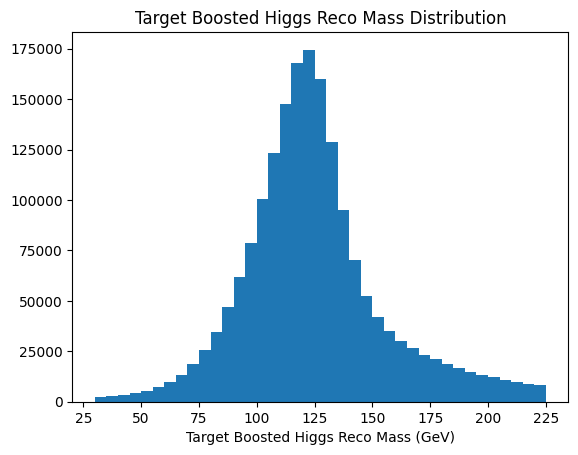

In [25]:
plt.hist(bH_reco_mass, bins=np.arange(30, 230, 5))
plt.title("Target Boosted Higgs Reco Mass Distribution")
plt.xlabel('Target Boosted Higgs Reco Mass (GeV)')

## Calculate the weight of each target

### calcualte the weight of each mass bin

In [26]:
# calculate mass density
bins = np.arange(75, 180, 5)
rH_mass_density, bins = np.histogram(rH_reco_mass, bins=bins, density=True)
bH_mass_density, bins = np.histogram(bH_reco_mass, bins=bins, density=True)

# calculate flat density
flat_density = 1/len(bins[:-1])

# calculate weight per bin
# mass density x weight = flat density
rH_weight = flat_density/rH_mass_density
bH_weight = flat_density/bH_mass_density

### find which bin a target is

In [27]:
# caluclate target reco mass
resolved_target_mass = (b1s+b2s).M
boosted_target_mass = bb.M

In [28]:
# find which mass bin the target is
resolved_mass_bin_idx = np.digitize(resolved_target_mass, bins)
boosted_mass_bin_idx = np.digitize(boosted_target_mass, bins)

In [29]:
resolved_target_weight = ak.ones_like(resolved_target_mass)
resolved_target_weight = np.array(resolved_target_weight)

In [30]:
boosted_target_weight = ak.ones_like(boosted_target_mass)
boosted_target_weight = np.array(boosted_target_weight)

In [31]:
# first and last bin weight is one
for i in range(1, len(bins)):
    resolved_in_bin_i = resolved_mass_bin_idx == i
    boosted_in_bin_i = boosted_mass_bin_idx == i
    
    resolved_target_weight[resolved_in_bin_i] = rH_weight[i-1]
    boosted_target_weight[boosted_in_bin_i] = bH_weight[i-1]

## Plot weights

<BarContainer object of 20 artists>

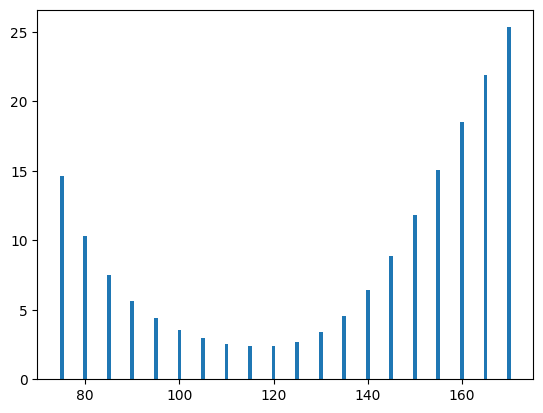

In [40]:
plt.bar(x=np.arange(75, 175, 5), height=rH_weight)

## Validate weight

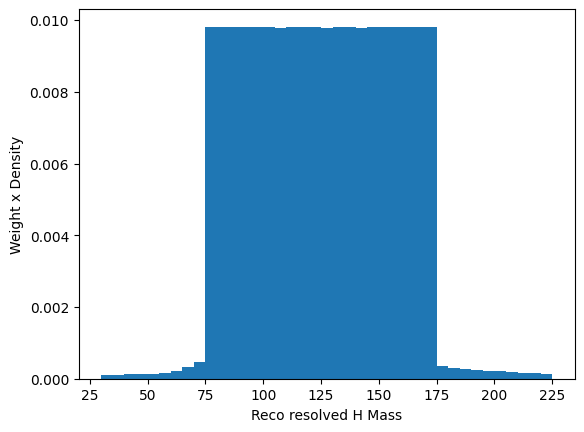

In [40]:
plt.hist(resolved_target_mass[rh_mask], bins=np.arange(30, 230, 5), weights=resolved_target_weight[rh_mask], density=True)
plt.xlabel('Reco resolved H Mass')
plt.ylabel('Weight x Density')
plt.show()

(array([0.01000079, 0.00999994, 0.01000135, 0.00999906, 0.01000158,
        0.00999568, 0.01001068, 0.00999018, 0.01001107, 0.01000281,
        0.00998306, 0.01002262, 0.01000155, 0.00999508, 0.00999969,
        0.00999342, 0.00999894, 0.00999683, 0.01000268, 0.009993  ]),
 array([ 75.,  80.,  85.,  90.,  95., 100., 105., 110., 115., 120., 125.,
        130., 135., 140., 145., 150., 155., 160., 165., 170., 175.]),
 <BarContainer object of 20 artists>)

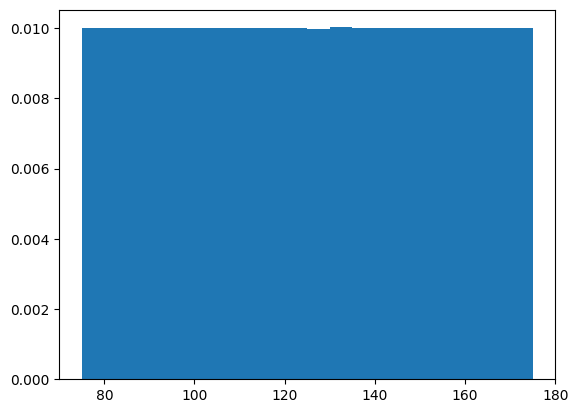

In [33]:
plt.hist(boosted_target_mass[bh_mask], bins=bins, weights=boosted_target_weight[bh_mask], density=True)

## Copy dataset, add target weight, and dump the new dataset

In [34]:
for i in range(1, 4):
    exec(
        f"f.create_dataset(\'TARGETS/h{i}/WEIGHT\', data=resolved_target_weight[:, {i-1}])"
    )
    exec(
        f"f.create_dataset(\'TARGETS/bh{i}/WEIGHT\', data=boosted_target_weight[:, {i-1}])"
    )

In [35]:
f['TARGETS']['h1'].keys()

<KeysViewHDF5 ['WEIGHT', 'b1', 'b2', 'mask', 'mh', 'pt']>

In [37]:
f['TARGETS']['bh1'].keys()

<KeysViewHDF5 ['WEIGHT', 'bb', 'mask', 'mh', 'pt']>